## Physics Informed Neural Networks to Approximate Solution of PDEs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch
from torch.utils.data import DataLoader
from Common import NeuralNet, MultiVariatePoly
import time
torch.autograd.set_detect_anomaly(True)
torch.manual_seed(128)

Consider the one-dimensional heat equation:

$$
u_t(t, x) = u_{xx}(t, x), \quad t\in[0,T], ~x\in [-1,1]
$$

with zero Dirichlet boundary conditions

$$
u_b(t, -1)=u_b(t,1)=0, 
$$

and initial condition

$$
u(x, 0) = u_0(x) = - \sin(\pi x)
$$

We want to obtain an approximate solution of the heat equation $u : [0,T]\times[-1,1] \mapsto \mathbb{R}$ with physics informed neural networks (PINNs).

To do so, we approximate the underlying solution with a feedforward dense neural network with tunable parameters $\theta$:

$$
u_\theta(t,x) \approx u(t,x)
$$
Define the following residuals:

   - Interior residual given by,

   $$r_{int,\theta}(t, x):=  u_{\theta, t}(x,t) - u_{\theta, xx}(x,t), \quad \forall ~t \in [0,T],~ x \in [-1,1].$$
   
        
      
        
   - Spatial boundary residual given by,
   
        $$r_{sb,\theta}(t,-1):= u_{\theta}(t,-1)- u_b(t,-1), \quad r_{sb,\theta}(t,1):= u_{\theta}(t,1)- u_b(t,1), \quad \forall t \in (0,T].$$
        
   - Temporal boundary residual given by,
   
        $$r_{tb,\theta}(x):= u_{\theta}(x,0) - u_0(x), \quad \forall x \in [-1,1].$$

and compute the corresponding loss functions:

$$
L_{int}(\theta) = \int_{[0,T]\times[-1,1]}r_{int,\theta}^2(t, x) dtdx, \quad
L_{sb}(\theta) = \int_{[0,T]}r_{sb,\theta}^2(t,-1) dt + \int_{[0,T]}r_{sb,\theta}^2(t,1)dt, \quad
L_{tb}(\theta) = \int_{[-1,1]}r_{tb,\theta}^2(x) dx
$$

The loss functions include integrals that can be approximated by suitable quadrature rule. We use quasi Monte-Carlo and accordingly define the following training sets

$$
S_{int} =\{y_n\}, \quad 1 \leq n \leq N_{int},\quad y_n = (x,t)_n \in D_T,
$$

$$
S_{sb, -1} =\{t_n, u_b(t_n,-1) \}, \quad1 \leq n \leq N_{sb}, t_n \in [0,T],
$$

$$
S_{sb, 1} =\{t_n, u_b(t_n,1) \}, \quad1 \leq n \leq N_{sb}, t_n \in [0,T],
$$

$$
S_{tb}=\{x_n, u_0(x_n)\}\quad  1 \leq n \leq N_{tb}, x_n \in [-1,1].
$$

with the training inputs points corresponding to low-discrepancy Sobol sequences.

$$
L_{int}(\theta) = \frac{1}{N_{int}}\sum_{i=1}^{N_{int}}r_{int,\theta}^2(y_n), \quad
L_{sb}(\theta) = \frac{1}{N_{sb}}\sum_{i=1}^{N_{sb}}r_{sb,\theta}^2(t_n,-1) + \frac{1}{N_{sb}}\sum_{i=1}^{N_{sb}}r_{sb,\theta}^2(t_n,1), \quad
L_{tb}(\theta) = \frac{1}{N_{tb}}\sum_{i=1}^{N_{tb}}r_{tb,\theta}^2(x_n)
$$

and solve the following minimization problem

$$
\theta^\ast = argmin_{\theta} \Big(L_{int}(\theta) + \lambda_u L_u(\theta)\Big)
$$

with

$$
L_u(\theta) = L_{tb}(\theta) + L_{sb}(\theta)
$$



In [2]:
class Pinns:
    def __init__(self, n_int_, n_sb_, n_tb_):
        self.n_int = n_int_
        self.n_sb = n_sb_
        self.n_tb = n_tb_

        # Extrema of the solution domain (t,x) in [0,0.1]x[-1,1]
        self.domain_extrema = torch.tensor([[0, 0.1],  # Time dimension
                                            [-1, 1]])  # Space dimension

        # Number of space dimensions
        self.space_dimensions = 1

        # Parameter to balance role of data and PDE
        self.lambda_u = 10

        # F Dense NN to approximate the solution of the underlying heat equation
        self.approximate_solution = NeuralNet(input_dimension=self.domain_extrema.shape[0], output_dimension=1,
                                              n_hidden_layers=4,
                                              neurons=20,
                                              regularization_param=0.,
                                              regularization_exp=2.,
                                              retrain_seed=42)
        '''self.approximate_solution = MultiVariatePoly(self.domain_extrema.shape[0], 3)'''

        # Generator of Sobol sequences
        self.soboleng = torch.quasirandom.SobolEngine(dimension=self.domain_extrema.shape[0])

        # Training sets S_sb, S_tb, S_int as torch dataloader
        self.training_set_sb, self.training_set_tb, self.training_set_int = self.assemble_datasets()

    ################################################################################################
    # Function to linearly transform a tensor whose value are between 0 and 1
    # to a tensor whose values are between the domain extrema
    def convert(self, tens):
        assert (tens.shape[1] == self.domain_extrema.shape[0])
        return tens * (self.domain_extrema[:, 1] - self.domain_extrema[:, 0]) + self.domain_extrema[:, 0]

    # Initial condition to solve the heat equation u0(x)=-sin(pi x)
    def initial_condition(self, x):
        return -torch.sin(np.pi * x)

    # Exact solution for the heat equation ut = u_xx with the IC above
    def exact_solution(self, inputs):
        t = inputs[:, 0]
        x = inputs[:, 1]

        u = -torch.exp(-np.pi ** 2 * t) * torch.sin(np.pi * x)
        return u

    ################################################################################################
    # Function returning the input-output tensor required to assemble the training set S_tb corresponding to the temporal boundary
    def add_temporal_boundary_points(self):
        t0 = self.domain_extrema[0, 0]
        input_tb = self.convert(self.soboleng.draw(self.n_tb))
        input_tb[:, 0] = torch.full(input_tb[:, 0].shape, t0)
        output_tb = self.initial_condition(input_tb[:, 1]).reshape(-1, 1)

        return input_tb, output_tb

    # Function returning the input-output tensor required to assemble the training set S_sb corresponding to the spatial boundary
    def add_spatial_boundary_points(self):
        x0 = self.domain_extrema[1, 0]
        xL = self.domain_extrema[1, 1]

        input_sb = self.convert(self.soboleng.draw(self.n_sb))

        input_sb_0 = torch.clone(input_sb)
        input_sb_0[:, 1] = torch.full(input_sb_0[:, 1].shape, x0)

        input_sb_L = torch.clone(input_sb)
        input_sb_L[:, 1] = torch.full(input_sb_L[:, 1].shape, xL)

        output_sb_0 = torch.zeros((input_sb.shape[0], 1))
        output_sb_L = torch.zeros((input_sb.shape[0], 1))

        return torch.cat([input_sb_0, input_sb_L], 0), torch.cat([output_sb_0, output_sb_L], 0)

    #  Function returning the input-output tensor required to assemble the training set S_int corresponding to the interior domain where the PDE is enforced
    def add_interior_points(self):
        input_int = self.convert(self.soboleng.draw(self.n_int))
        output_int = torch.zeros((input_int.shape[0], 1))
        return input_int, output_int

    # Function returning the training sets S_sb, S_tb, S_int as dataloader
    def assemble_datasets(self):
        input_sb, output_sb = self.add_spatial_boundary_points()   # S_sb
        input_tb, output_tb = self.add_temporal_boundary_points()  # S_tb
        input_int, output_int = self.add_interior_points()         # S_int

        training_set_sb = DataLoader(torch.utils.data.TensorDataset(input_sb, output_sb), batch_size=2*self.space_dimensions*self.n_sb, shuffle=False)
        training_set_tb = DataLoader(torch.utils.data.TensorDataset(input_tb, output_tb), batch_size=self.n_tb, shuffle=False)
        training_set_int = DataLoader(torch.utils.data.TensorDataset(input_int, output_int), batch_size=self.n_int, shuffle=False)

        return training_set_sb, training_set_tb, training_set_int

    ################################################################################################
    # Function to compute the terms required in the definition of the TEMPORAL boundary residual
    def apply_initial_condition(self, input_tb):
        u_pred_tb = self.approximate_solution(input_tb)
        return u_pred_tb

    # Function to compute the terms required in the definition of the SPATIAL boundary residual
    def apply_boundary_conditions(self, input_sb):
        u_pred_sb = self.approximate_solution(input_sb)

        return u_pred_sb

    # Function to compute the PDE residuals
    def compute_pde_residual(self, input_int):
        input_int.requires_grad = True
        u = self.approximate_solution(input_int)

        # grad compute the gradient of a "SCALAR" function L with respect to some input nxm TENSOR Z=[[x1, y1],[x2,y2],[x3,y3],...,[xn,yn]], m=2
        # it returns grad_L = [[dL/dx1, dL/dy1],[dL/dx2, dL/dy2],[dL/dx3, dL/dy3],...,[dL/dxn, dL/dyn]]
        # Note: pytorch considers a tensor [u1, u2,u3, ... ,un] a vectorial function
        # whereas sum_u = u1 + u2 u3 + u4 + ... + un as a "scalar" one

        # In our case ui = u(xi), therefore the line below returns:
        # grad_u = [[dsum_u/dx1, dsum_u/dy1],[dsum_u/dx2, dsum_u/dy2],[dsum_u/dx3, dL/dy3],...,[dsum_u/dxm, dsum_u/dyn]]
        # and dsum_u/dxi = d(u1 + u2 u3 + u4 + ... + un)/dxi = d(u(x1) + u(x2) u3(x3) + u4(x4) + ... + u(xn))/dxi = dui/dxi
        grad_u = torch.autograd.grad(u.sum(), input_int, create_graph=True)[0]
        grad_u_t = grad_u[:, 0]
        grad_u_x = grad_u[:, 1]
        grad_u_xx = torch.autograd.grad(grad_u_x.sum(), input_int, create_graph=True)[0][:, 1]

        residual = grad_u_t - grad_u_xx
        return residual.reshape(-1, )

    # Function to compute the total loss (weighted sum of spatial boundary loss, temporal boundary loss and interior loss)
    def compute_loss(self, inp_train_sb, u_train_sb, inp_train_tb, u_train_tb, inp_train_int, verbose=True):
        u_pred_sb = self.apply_boundary_conditions(inp_train_sb)
        u_pred_tb = self.apply_initial_condition(inp_train_tb)

        assert (u_pred_sb.shape[1] == u_train_sb.shape[1])
        assert (u_pred_tb.shape[1] == u_train_tb.shape[1])


        r_int = self.compute_pde_residual(inp_train_int)
        r_sb = u_train_sb - u_pred_sb
        r_tb = u_train_tb - u_pred_tb

        loss_sb = torch.mean(abs(r_sb) ** 2)
        loss_tb = torch.mean(abs(r_tb) ** 2)
        loss_int = torch.mean(abs(r_int) ** 2)

        loss_u = loss_sb + loss_tb

        loss = torch.log10(self.lambda_u * (loss_sb + loss_tb) + loss_int)
        if verbose: print("Total loss: ", round(loss.item(), 4), "| PDE Loss: ", round(torch.log10(loss_u).item(), 4), "| Function Loss: ", round(torch.log10(loss_int).item(), 4))

        return loss

    ################################################################################################
    def fit(self, num_epochs, optimizer, verbose=True):
        history = list()

        # Loop over epochs
        for epoch in range(num_epochs):
            if verbose: print("################################ ", epoch, " ################################")

            for j, ((inp_train_sb, u_train_sb), (inp_train_tb, u_train_tb), (inp_train_int, u_train_int)) in enumerate(zip(self.training_set_sb, self.training_set_tb, self.training_set_int)):
                def closure():
                    optimizer.zero_grad()
                    loss = self.compute_loss(inp_train_sb, u_train_sb, inp_train_tb, u_train_tb, inp_train_int, verbose=verbose)
                    loss.backward()

                    history.append(loss.item())
                    return loss

                optimizer.step(closure=closure)

        print('Final Loss: ', history[-1])

        return history

    ################################################################################################
    def plotting(self):
        inputs = self.soboleng.draw(100000)
        inputs = self.convert(inputs)

        output = self.approximate_solution(inputs).reshape(-1, )
        exact_output = self.exact_solution(inputs).reshape(-1, )

        fig, axs = plt.subplots(1, 2, figsize=(16, 8), dpi=150)
        im1 = axs[0].scatter(inputs[:, 1].detach(), inputs[:, 0].detach(), c=exact_output.detach(), cmap="jet")
        axs[0].set_xlabel("x")
        axs[0].set_ylabel("t")
        plt.colorbar(im1, ax=axs[0])
        axs[0].grid(True, which="both", ls=":")
        im2 = axs[1].scatter(inputs[:, 1].detach(), inputs[:, 0].detach(), c=output.detach(), cmap="jet")
        axs[1].set_xlabel("x")
        axs[1].set_ylabel("t")
        plt.colorbar(im2, ax=axs[1])
        axs[1].grid(True, which="both", ls=":")
        axs[0].set_title("Exact Solution")
        axs[1].set_title("Approximate Solution")

        plt.show()

        err = (torch.mean((output - exact_output) ** 2) / torch.mean(exact_output ** 2)) ** 0.5 * 100
        print("L2 Relative Error Norm: ", err.item(), "%")


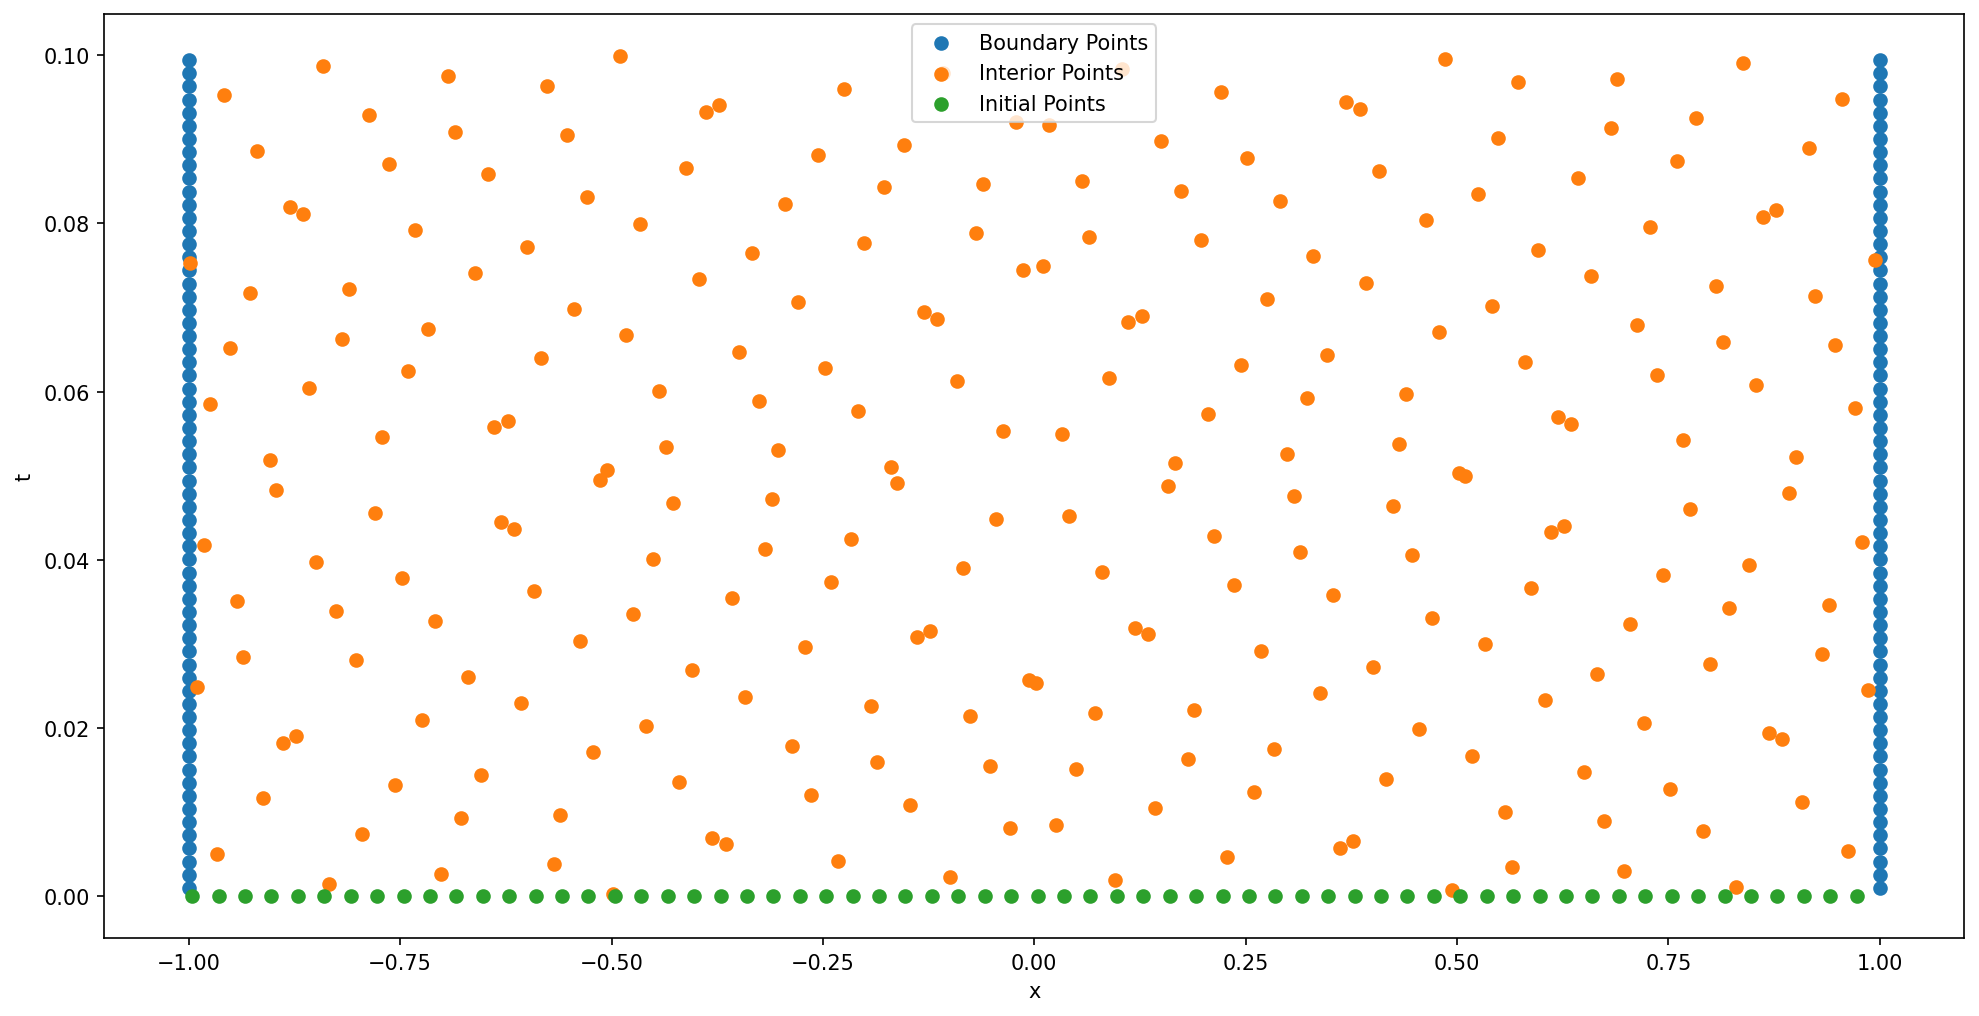

In [4]:
# Plot the input training points
input_sb_, output_sb_ = pinn.add_spatial_boundary_points()
input_tb_, output_tb_ = pinn.add_temporal_boundary_points()
input_int_, output_int_ = pinn.add_interior_points()

plt.figure(figsize=(16, 8), dpi=150)
plt.scatter(input_sb_[:, 1].detach().numpy(), input_sb_[:, 0].detach().numpy(), label="Boundary Points")
plt.scatter(input_int_[:, 1].detach().numpy(), input_int_[:, 0].detach().numpy(), label="Interior Points")
plt.scatter(input_tb_[:, 1].detach().numpy(), input_tb_[:, 0].detach().numpy(), label="Initial Points")
plt.xlabel("x")
plt.ylabel("t")
plt.legend()
plt.show()

In [5]:
n_epochs = 1
optimizer_LBFGS = optim.LBFGS(pinn.approximate_solution.parameters(),
                              lr=float(0.5),
                              max_iter=50000,
                              max_eval=50000,
                              history_size=150,
                              line_search_fn="strong_wolfe",
                              tolerance_change=1.0 * np.finfo(float).eps)
optimizer_ADAM = optim.Adam(pinn.approximate_solution.parameters(),
                            lr=float(0.001))

################################  0  ################################
Total loss:  1.6025 | PDE Loss:  -0.0044 | Function Loss:  1.4792
Total loss:  1.5304 | PDE Loss:  -0.1168 | Function Loss:  1.4196
Total loss:  1.1947 | PDE Loss:  0.0294 | Function Loss:  0.6951
Total loss:  0.9989 | PDE Loss:  -0.1983 | Function Loss:  0.5612
Total loss:  0.8499 | PDE Loss:  -0.2979 | Function Loss:  0.3099
Total loss:  0.6718 | PDE Loss:  -0.3988 | Function Loss:  -0.1523
Total loss:  0.5687 | PDE Loss:  -0.5161 | Function Loss:  -0.1824
Total loss:  0.5251 | PDE Loss:  -0.554 | Function Loss:  -0.2532
Total loss:  0.5079 | PDE Loss:  -0.5645 | Function Loss:  -0.3058
Total loss:  0.4933 | PDE Loss:  -0.579 | Function Loss:  -0.321
Total loss:  0.4756 | PDE Loss:  -0.6 | Function Loss:  -0.3204
Total loss:  0.4585 | PDE Loss:  -0.6185 | Function Loss:  -0.3306
Total loss:  0.441 | PDE Loss:  -0.6357 | Function Loss:  -0.3496
Total loss:  0.4198 | PDE Loss:  -0.6507 | Function Loss:  -0.4047
Total

Total loss:  -1.4142 | PDE Loss:  -2.7285 | Function Loss:  -1.7024
Total loss:  -1.4162 | PDE Loss:  -2.7251 | Function Loss:  -1.7096
Total loss:  -1.4193 | PDE Loss:  -2.7217 | Function Loss:  -1.7189
Total loss:  -1.4237 | PDE Loss:  -2.7199 | Function Loss:  -1.7296
Total loss:  -1.4286 | PDE Loss:  -2.7286 | Function Loss:  -1.7306
Total loss:  -1.4364 | PDE Loss:  -2.7409 | Function Loss:  -1.7339
Total loss:  -1.4501 | PDE Loss:  -2.7678 | Function Loss:  -1.7351
Total loss:  -1.4705 | PDE Loss:  -2.815 | Function Loss:  -1.7321
Total loss:  -1.4948 | PDE Loss:  -2.8709 | Function Loss:  -1.7318
Total loss:  -1.5159 | PDE Loss:  -2.9249 | Function Loss:  -1.7306
Total loss:  -1.5455 | PDE Loss:  -2.9968 | Function Loss:  -1.7351
Total loss:  -1.584 | PDE Loss:  -3.058 | Function Loss:  -1.7617
Total loss:  -1.6167 | PDE Loss:  -3.1033 | Function Loss:  -1.7882
Total loss:  -1.6557 | PDE Loss:  -3.1485 | Function Loss:  -1.8242
Total loss:  -1.667 | PDE Loss:  -3.092 | Function 

Total loss:  -2.4427 | PDE Loss:  -3.702 | Function Loss:  -2.7899
Total loss:  -2.457 | PDE Loss:  -3.7233 | Function Loss:  -2.7958
Total loss:  -2.4685 | PDE Loss:  -3.7339 | Function Loss:  -2.8084
Total loss:  -2.4745 | PDE Loss:  -3.7391 | Function Loss:  -2.8152
Total loss:  -2.4788 | PDE Loss:  -3.7526 | Function Loss:  -2.8088
Total loss:  -2.4829 | PDE Loss:  -3.7529 | Function Loss:  -2.8174
Total loss:  -2.4866 | PDE Loss:  -3.7557 | Function Loss:  -2.8221
Total loss:  -2.4919 | PDE Loss:  -3.7613 | Function Loss:  -2.8269
Total loss:  -2.4972 | PDE Loss:  -3.771 | Function Loss:  -2.8272
Total loss:  -2.5043 | PDE Loss:  -3.7806 | Function Loss:  -2.8315
Total loss:  -2.5139 | PDE Loss:  -3.8016 | Function Loss:  -2.8286
Total loss:  -2.5262 | PDE Loss:  -3.8256 | Function Loss:  -2.8289
Total loss:  -2.5436 | PDE Loss:  -3.8678 | Function Loss:  -2.8226
Total loss:  -2.5654 | PDE Loss:  -3.9204 | Function Loss:  -2.8184
Total loss:  -2.5552 | PDE Loss:  -4.02 | Function 

Total loss:  -3.0456 | PDE Loss:  -4.7188 | Function Loss:  -3.1492
Total loss:  -3.0478 | PDE Loss:  -4.7094 | Function Loss:  -3.1546
Total loss:  -3.0497 | PDE Loss:  -4.7025 | Function Loss:  -3.159
Total loss:  -3.0513 | PDE Loss:  -4.6938 | Function Loss:  -3.1636
Total loss:  -3.0529 | PDE Loss:  -4.6866 | Function Loss:  -3.1678
Total loss:  -3.0546 | PDE Loss:  -4.6798 | Function Loss:  -3.1721
Total loss:  -3.0563 | PDE Loss:  -4.6722 | Function Loss:  -3.1767
Total loss:  -3.058 | PDE Loss:  -4.6659 | Function Loss:  -3.181
Total loss:  -3.0596 | PDE Loss:  -4.6608 | Function Loss:  -3.1848
Total loss:  -3.0616 | PDE Loss:  -4.6548 | Function Loss:  -3.1896
Total loss:  -3.0644 | PDE Loss:  -4.6506 | Function Loss:  -3.1947
Total loss:  -3.0665 | PDE Loss:  -4.6405 | Function Loss:  -3.2012
Total loss:  -3.0687 | PDE Loss:  -4.6375 | Function Loss:  -3.2053
Total loss:  -3.0708 | PDE Loss:  -4.6338 | Function Loss:  -3.2096
Total loss:  -3.0732 | PDE Loss:  -4.6281 | Functio

Total loss:  -3.5633 | PDE Loss:  -5.5659 | Function Loss:  -3.6088
Total loss:  -3.5658 | PDE Loss:  -5.5686 | Function Loss:  -3.6112
Total loss:  -3.5695 | PDE Loss:  -5.5767 | Function Loss:  -3.6145
Total loss:  -3.5736 | PDE Loss:  -5.5863 | Function Loss:  -3.618
Total loss:  -3.5775 | PDE Loss:  -5.5981 | Function Loss:  -3.6211
Total loss:  -3.5814 | PDE Loss:  -5.6055 | Function Loss:  -3.6246
Total loss:  -3.585 | PDE Loss:  -5.6164 | Function Loss:  -3.6274
Total loss:  -3.5876 | PDE Loss:  -5.6217 | Function Loss:  -3.6298
Total loss:  -3.5907 | PDE Loss:  -5.6277 | Function Loss:  -3.6325
Total loss:  -3.5954 | PDE Loss:  -5.6302 | Function Loss:  -3.6374
Total loss:  -3.5996 | PDE Loss:  -5.6415 | Function Loss:  -3.641
Total loss:  -3.6035 | PDE Loss:  -5.6411 | Function Loss:  -3.6453
Total loss:  -3.6084 | PDE Loss:  -5.6358 | Function Loss:  -3.6512
Total loss:  -3.6118 | PDE Loss:  -5.6126 | Function Loss:  -3.6575
Total loss:  -3.6151 | PDE Loss:  -5.6028 | Functio

Total loss:  -3.9277 | PDE Loss:  -5.7401 | Function Loss:  -4.0004
Total loss:  -3.9306 | PDE Loss:  -5.762 | Function Loss:  -3.9999
Total loss:  -3.9328 | PDE Loss:  -5.7752 | Function Loss:  -4.0002
Total loss:  -3.9353 | PDE Loss:  -5.8095 | Function Loss:  -3.9976
Total loss:  -3.9368 | PDE Loss:  -5.8186 | Function Loss:  -3.9979
Total loss:  -3.939 | PDE Loss:  -5.8318 | Function Loss:  -3.9985
Total loss:  -3.9406 | PDE Loss:  -5.8465 | Function Loss:  -3.9982
Total loss:  -3.9418 | PDE Loss:  -5.86 | Function Loss:  -3.9977
Total loss:  -3.9431 | PDE Loss:  -5.8648 | Function Loss:  -3.9985
Total loss:  -3.9438 | PDE Loss:  -5.8878 | Function Loss:  -3.9963
Total loss:  -3.9447 | PDE Loss:  -5.888 | Function Loss:  -3.9972
Total loss:  -3.9455 | PDE Loss:  -5.8891 | Function Loss:  -3.998
Total loss:  -3.9465 | PDE Loss:  -5.8919 | Function Loss:  -3.9988
Total loss:  -3.9477 | PDE Loss:  -5.8967 | Function Loss:  -3.9995
Total loss:  -3.949 | PDE Loss:  -5.9045 | Function Lo

Total loss:  -4.1612 | PDE Loss:  -6.1982 | Function Loss:  -4.2031
Total loss:  -4.1636 | PDE Loss:  -6.1972 | Function Loss:  -4.2058
Total loss:  -4.1648 | PDE Loss:  -6.1982 | Function Loss:  -4.207
Total loss:  -4.1673 | PDE Loss:  -6.1914 | Function Loss:  -4.2105
Total loss:  -4.1688 | PDE Loss:  -6.1911 | Function Loss:  -4.2121
Total loss:  -4.171 | PDE Loss:  -6.1882 | Function Loss:  -4.2149
Total loss:  -4.1731 | PDE Loss:  -6.1804 | Function Loss:  -4.218
Total loss:  -4.1749 | PDE Loss:  -6.182 | Function Loss:  -4.2199
Total loss:  -4.176 | PDE Loss:  -6.184 | Function Loss:  -4.2209
Total loss:  -4.1772 | PDE Loss:  -6.184 | Function Loss:  -4.2222
Total loss:  -4.1787 | PDE Loss:  -6.1847 | Function Loss:  -4.2238
Total loss:  -4.1808 | PDE Loss:  -6.1882 | Function Loss:  -4.2257
Total loss:  -4.1827 | PDE Loss:  -6.1895 | Function Loss:  -4.2277
Total loss:  -4.1859 | PDE Loss:  -6.1938 | Function Loss:  -4.2308
Total loss:  -4.1883 | PDE Loss:  -6.1991 | Function Lo

Total loss:  -4.5056 | PDE Loss:  -6.6333 | Function Loss:  -4.5393
Total loss:  -4.5062 | PDE Loss:  -6.6374 | Function Loss:  -4.5395
Total loss:  -4.5068 | PDE Loss:  -6.6389 | Function Loss:  -4.54
Total loss:  -4.5072 | PDE Loss:  -6.6431 | Function Loss:  -4.5402
Total loss:  -4.5079 | PDE Loss:  -6.6473 | Function Loss:  -4.5406
Total loss:  -4.5086 | PDE Loss:  -6.6497 | Function Loss:  -4.5412
Total loss:  -4.5093 | PDE Loss:  -6.6528 | Function Loss:  -4.5417
Total loss:  -4.5103 | PDE Loss:  -6.6543 | Function Loss:  -4.5426
Total loss:  -4.5114 | PDE Loss:  -6.6534 | Function Loss:  -4.5439
Total loss:  -4.5126 | PDE Loss:  -6.6517 | Function Loss:  -4.5453
Total loss:  -4.514 | PDE Loss:  -6.6464 | Function Loss:  -4.5473
Total loss:  -4.5158 | PDE Loss:  -6.6412 | Function Loss:  -4.5496
Total loss:  -4.5183 | PDE Loss:  -6.6348 | Function Loss:  -4.5529
Total loss:  -4.5204 | PDE Loss:  -6.6307 | Function Loss:  -4.5555
Total loss:  -4.5236 | PDE Loss:  -6.6175 | Functio

Total loss:  -4.7031 | PDE Loss:  -7.0458 | Function Loss:  -4.7233
Total loss:  -4.7039 | PDE Loss:  -7.0486 | Function Loss:  -4.724
Total loss:  -4.7047 | PDE Loss:  -7.0497 | Function Loss:  -4.7248
Total loss:  -4.7055 | PDE Loss:  -7.0493 | Function Loss:  -4.7257
Total loss:  -4.7064 | PDE Loss:  -7.0465 | Function Loss:  -4.7267
Total loss:  -4.7069 | PDE Loss:  -7.0399 | Function Loss:  -4.7275
Total loss:  -4.7074 | PDE Loss:  -7.0377 | Function Loss:  -4.7282
Total loss:  -4.7077 | PDE Loss:  -7.0355 | Function Loss:  -4.7286
Total loss:  -4.708 | PDE Loss:  -7.0309 | Function Loss:  -4.7291
Total loss:  -4.7082 | PDE Loss:  -7.0266 | Function Loss:  -4.7296
Total loss:  -4.7084 | PDE Loss:  -7.0228 | Function Loss:  -4.73
Total loss:  -4.7085 | PDE Loss:  -7.0196 | Function Loss:  -4.7303
Total loss:  -4.7088 | PDE Loss:  -7.0166 | Function Loss:  -4.7307
Total loss:  -4.7089 | PDE Loss:  -7.0138 | Function Loss:  -4.731
Total loss:  -4.7092 | PDE Loss:  -7.0114 | Function 

Total loss:  -4.8608 | PDE Loss:  -6.738 | Function Loss:  -4.9226
Total loss:  -4.8619 | PDE Loss:  -6.7522 | Function Loss:  -4.9217
Total loss:  -4.8625 | PDE Loss:  -6.7644 | Function Loss:  -4.9207
Total loss:  -4.8631 | PDE Loss:  -6.7758 | Function Loss:  -4.9197
Total loss:  -4.8636 | PDE Loss:  -6.7875 | Function Loss:  -4.9187
Total loss:  -4.8641 | PDE Loss:  -6.799 | Function Loss:  -4.9177
Total loss:  -4.8646 | PDE Loss:  -6.8063 | Function Loss:  -4.9174
Total loss:  -4.8651 | PDE Loss:  -6.8112 | Function Loss:  -4.9173
Total loss:  -4.8655 | PDE Loss:  -6.8111 | Function Loss:  -4.9177
Total loss:  -4.8658 | PDE Loss:  -6.8089 | Function Loss:  -4.9184
Total loss:  -4.8661 | PDE Loss:  -6.8044 | Function Loss:  -4.9193
Total loss:  -4.8662 | PDE Loss:  -6.8001 | Function Loss:  -4.92
Total loss:  -4.8663 | PDE Loss:  -6.7959 | Function Loss:  -4.9207
Total loss:  -4.8664 | PDE Loss:  -6.793 | Function Loss:  -4.9212
Total loss:  -4.8665 | PDE Loss:  -6.7907 | Function 

Total loss:  -5.1241 | PDE Loss:  -7.5853 | Function Loss:  -5.1394
Total loss:  -5.1247 | PDE Loss:  -7.5884 | Function Loss:  -5.1399
Total loss:  -5.1255 | PDE Loss:  -7.5915 | Function Loss:  -5.1406
Total loss:  -5.1264 | PDE Loss:  -7.5959 | Function Loss:  -5.1414
Total loss:  -5.1274 | PDE Loss:  -7.6006 | Function Loss:  -5.1422
Total loss:  -5.128 | PDE Loss:  -7.6077 | Function Loss:  -5.1426
Total loss:  -5.1286 | PDE Loss:  -7.612 | Function Loss:  -5.1431
Total loss:  -5.1291 | PDE Loss:  -7.6178 | Function Loss:  -5.1434
Total loss:  -5.13 | PDE Loss:  -7.6287 | Function Loss:  -5.144
Total loss:  -5.1306 | PDE Loss:  -7.6427 | Function Loss:  -5.1442
Total loss:  -5.1313 | PDE Loss:  -7.6542 | Function Loss:  -5.1445
Total loss:  -5.1317 | PDE Loss:  -7.6644 | Function Loss:  -5.1447
Total loss:  -5.1321 | PDE Loss:  -7.6712 | Function Loss:  -5.1449
Total loss:  -5.1325 | PDE Loss:  -7.6755 | Function Loss:  -5.1451
Total loss:  -5.1328 | PDE Loss:  -7.6787 | Function 

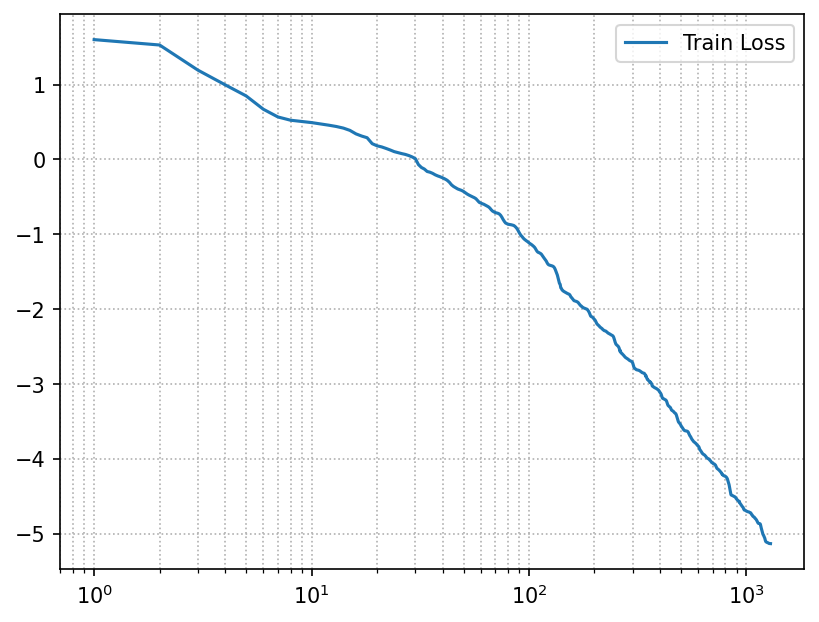

In [6]:
hist = pinn.fit(num_epochs=n_epochs,
                optimizer=optimizer_LBFGS,
                verbose=True)

plt.figure(dpi=150)
plt.grid(True, which="both", ls=":")
plt.plot(np.arange(1, len(hist) + 1), hist, label="Train Loss")
plt.xscale("log")
plt.legend()

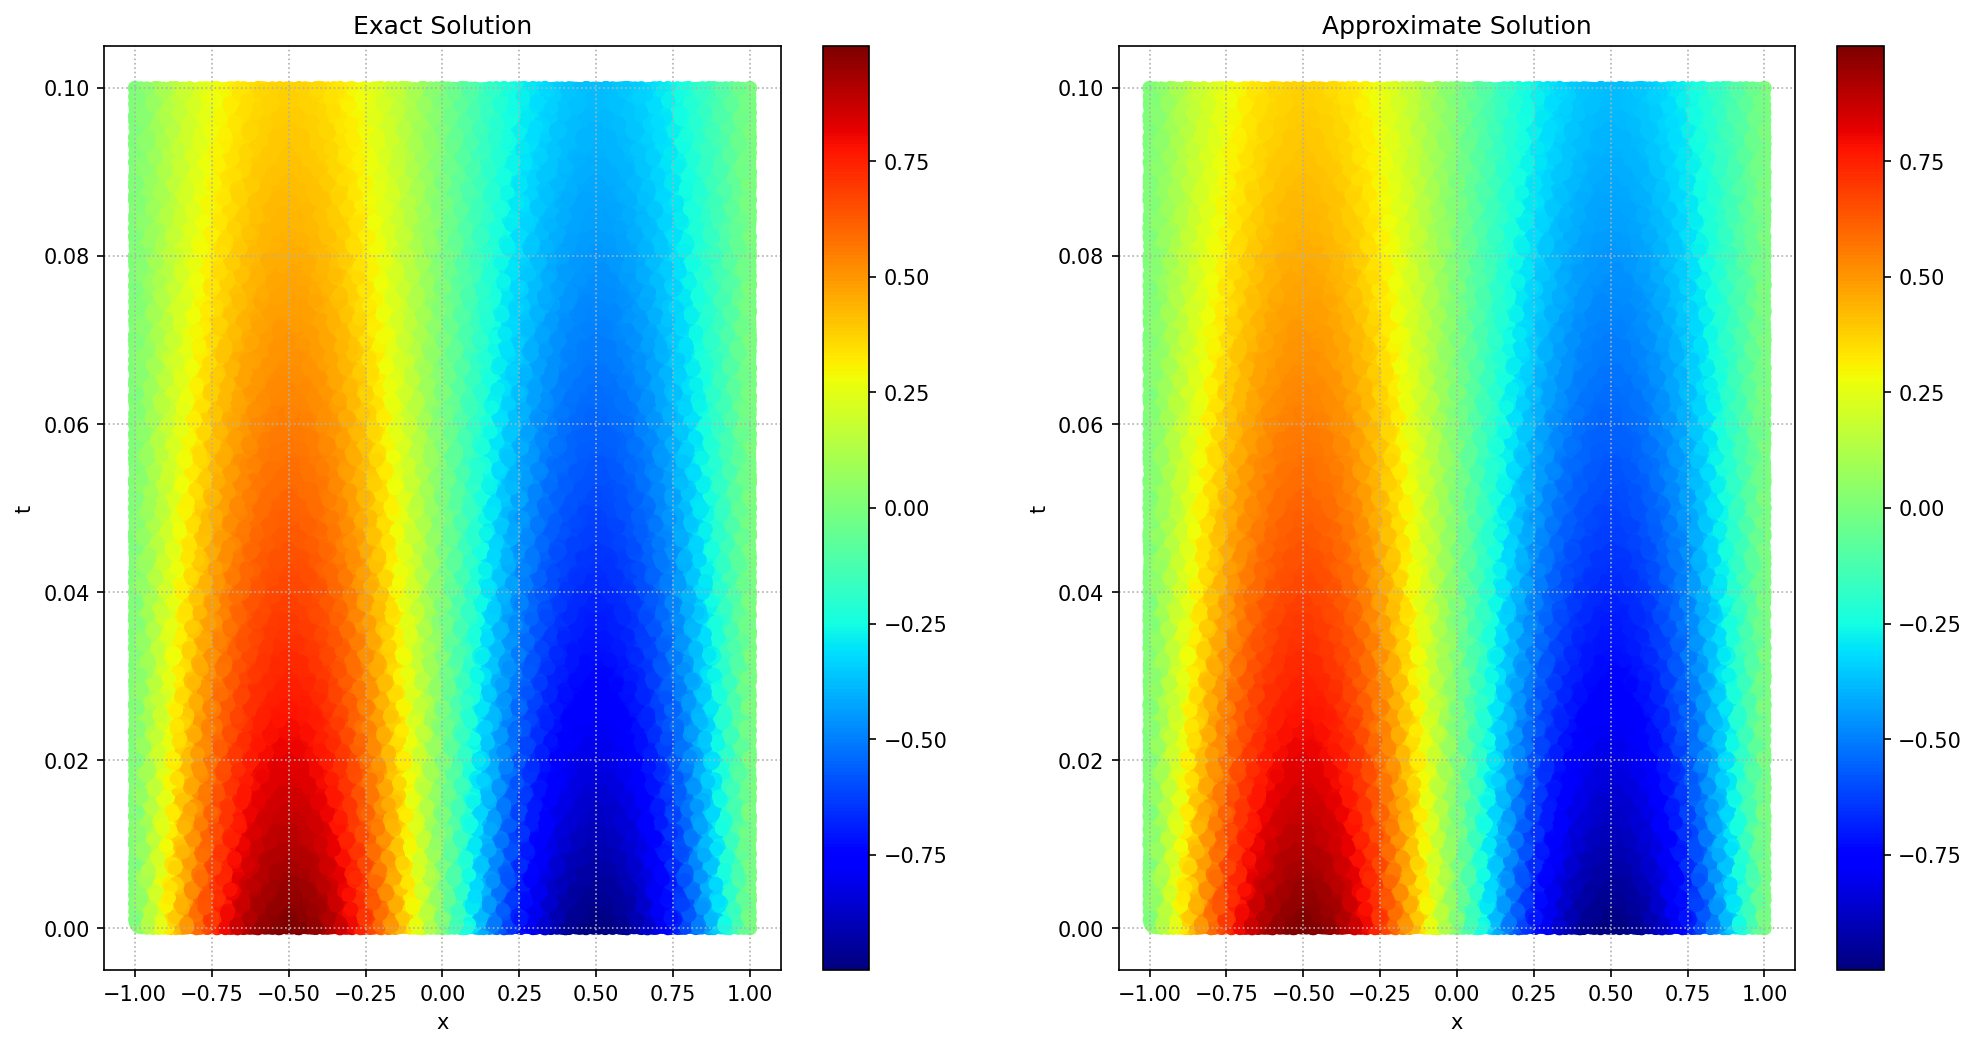

L2 Relative Error Norm:  0.007539168931543827 %


In [7]:
pinn.plotting()